<h1> Part 1

<h2> connecting to the Cassandra cluster

In [1]:
from cassandra.cluster import Cluster
try:
    cluster = Cluster(['p5-db-1', 'p5-db-2', 'p5-db-3'])
    cass = cluster.connect()
except Exception as e:
    print(e)

<h2> create weather station

In [2]:
try:  
    cass.execute("drop keyspace if exists weather")
    cass.execute("create keyspace weather with replication={'class':'SimpleStrategy', 'replication_factor':3}")
    cass.execute("create type weather.station_record (tmin int, tmax int)")
    cass.execute("create table weather.stations (id text, date date, name text static, record weather.station_record, PRIMARY KEY(id, date))")
except Exception as e:
    print(e)

In [3]:
# Q1: what is the schema?
print(cass.execute("describe keyspace weather").one().create_statement)
print(cass.execute("describe table weather.stations").one().create_statement)

CREATE KEYSPACE weather WITH replication = {'class': 'SimpleStrategy', 'replication_factor': '3'}  AND durable_writes = true;
CREATE TABLE weather.stations (
    id text,
    date date,
    name text static,
    record station_record,
    PRIMARY KEY (id, date)
) WITH CLUSTERING ORDER BY (date ASC)
    AND additional_write_policy = '99p'
    AND bloom_filter_fp_chance = 0.01
    AND caching = {'keys': 'ALL', 'rows_per_partition': 'NONE'}
    AND cdc = false
    AND comment = ''
    AND compaction = {'class': 'org.apache.cassandra.db.compaction.SizeTieredCompactionStrategy', 'max_threshold': '32', 'min_threshold': '4'}
    AND compression = {'chunk_length_in_kb': '16', 'class': 'org.apache.cassandra.io.compress.LZ4Compressor'}
    AND crc_check_chance = 1.0
    AND default_time_to_live = 0
    AND extensions = {}
    AND gc_grace_seconds = 864000
    AND max_index_interval = 2048
    AND memtable_flush_period_in_ms = 0
    AND min_index_interval = 128
    AND read_repair = 'BLOCKING'
  

<h2> Spark session

In [4]:
!curl https://pages.cs.wisc.edu/~harter/cs639/data/ghcnd-stations.txt -o ghcnd-stations.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10.1M  100 10.1M    0     0  7699k      0  0:00:01  0:00:01 --:--:-- 7701k


In [4]:
from pyspark.sql import SparkSession
spark = (SparkSession.builder
         .appName("p5")
         .config('spark.jars.packages', 'com.datastax.spark:spark-cassandra-connector_2.12:3.2.0')
         .config("spark.sql.extensions", "com.datastax.spark.connector.CassandraSparkExtensions")
         .getOrCreate())

:: loading settings :: url = jar:file:/usr/local/lib/python3.10/dist-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
com.datastax.spark#spark-cassandra-connector_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-fb53294c-e7f5-472e-880b-5fb3781748c5;1.0
	confs: [default]
	found com.datastax.spark#spark-cassandra-connector_2.12;3.2.0 in central
	found com.datastax.spark#spark-cassandra-connector-driver_2.12;3.2.0 in central
	found com.datastax.oss#java-driver-core-shaded;4.13.0 in central
	found com.datastax.oss#native-protocol;1.5.0 in central
	found com.datastax.oss#java-driver-shaded-guava;25.1-jre-graal-sub-1 in central
	found com.typesafe#config;1.4.1 in central
	found org.slf4j#slf4j-api;1.7.26 in central
	found io.dropwizard.metrics#metrics-core;4.1.18 in central
	found org.hdrhistogram#HdrHistogram;2.1.12 in central
	found org.reactivestreams#reactive-streams;1.0.3 in central
	found com.github.stephenc.jcip#jcip-annotations;1.0-1 in central
	found com.gith

In [5]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, trim, expr, udf
df = spark.read.text("ghcnd-stations.txt")
df = df.select(
    trim(col("value").substr(0, 11)).alias("id"),
    trim(col("value").substr(13, 8)).alias("lat"),
    trim(col("value").substr(22, 9)).alias("lon"),
    trim(col("value").substr(32, 6)).alias("elevation"),
    trim(col("value").substr(39, 2)).alias("state"),
    trim(col("value").substr(42, 30)).alias("name"),
)
df.show()

+-----------+-------+--------+---------+-----+--------------------+
|         id|    lat|     lon|elevation|state|                name|
+-----------+-------+--------+---------+-----+--------------------+
|ACW00011604|17.1167|-61.7833|     10.1|     |ST JOHNS COOLIDGE...|
|ACW00011647|17.1333|-61.7833|     19.2|     |            ST JOHNS|
|AE000041196|25.3330| 55.5170|     34.0|     | SHARJAH INTER. AIRP|
|AEM00041194|25.2550| 55.3640|     10.4|     |          DUBAI INTL|
|AEM00041217|24.4330| 54.6510|     26.8|     |      ABU DHABI INTL|
|AEM00041218|24.2620| 55.6090|    264.9|     |         AL AIN INTL|
|AF000040930|35.3170| 69.0170|   3366.0|     |        NORTH-SALANG|
|AFM00040938|34.2100| 62.2280|    977.2|     |               HERAT|
|AFM00040948|34.5660| 69.2120|   1791.3|     |          KABUL INTL|
|AFM00040990|31.5000| 65.8500|   1010.0|     |    KANDAHAR AIRPORT|
|AG000060390|36.7167|  3.2500|     24.0|     |  ALGER-DAR EL BEIDA|
|AG000060590|30.5667|  2.8667|    397.0|     |  

In [6]:
query = cass.prepare("INSERT INTO weather.stations (id, name) VALUES (?, ?)")
for row in df.filter("state = 'WI'").select("id", "name").collect():
    cass.execute(query, row)

In [7]:
row = cass.execute("SELECT token(id) as t, id, name FROM weather.stations WHERE id='USC00470273'").one()
token = row.t
print(token) # token of Arboretum sensor
row

-9014250178872933741


Row(t=-9014250178872933741, id='USC00470273', name='UW ARBORETUM - MADISON')

In [8]:
from subprocess import check_output
ring = str(check_output(["/apache-cassandra-4.0.7/bin/nodetool", "ring"]), "utf-8")
rows = [line.split() for line in ring.split("\n") if "rack1" in line]

In [9]:
print(ring)


Datacenter: datacenter1
Address          Rack        Status State   Load            Owns                Token                                       
                                                                                9219042714646091609                         
172.18.0.3       rack1       Up     Normal  86.51 KiB       100.00%             -8499653143662990515                        
172.18.0.4       rack1       Up     Normal  86.53 KiB       100.00%             -8307063176518901934                        
172.18.0.3       rack1       Up     Normal  86.51 KiB       100.00%             -7532288900584455016                        
172.18.0.2       rack1       Up     Normal  86.52 KiB       100.00%             -7449067058239872878                        
172.18.0.4       rack1       Up     Normal  86.53 KiB       100.00%             -7289211771776474918                        
172.18.0.4       rack1       Up     Normal  86.53 KiB       100.00%             -6471539839164124124

In [10]:
print(len(rows))

48


In [10]:
# Q2: what is the token of the vnode that comes first after the partition for the USC00470273 sensor?
# vnode = rows[0][-1]
for i, row in enumerate(rows):
    if token > int(row[-1]):
        vtoken = rows[(i+1) % len(rows)][-1]
        break
print("row token:  ", token)
print("vnode token:", vtoken)

row token:   -9014250178872933741
vnode token: -9139938639333111539


<h1> Part 2

In [42]:
!python3 -m grpc_tools.protoc -I=. --python_out=. --grpc_python_out=. station.proto

In [45]:
!wget https://pages.cs.wisc.edu/~harter/cs639/data/wi-stations.zip

--2023-03-22 05:23:48--  https://pages.cs.wisc.edu/~harter/cs639/data/wi-stations.zip
Resolving pages.cs.wisc.edu (pages.cs.wisc.edu)... 128.105.7.9
Connecting to pages.cs.wisc.edu (pages.cs.wisc.edu)|128.105.7.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133113222 (127M) [application/zip]
Saving to: ‘wi-stations.zip’

wi-stations.zip     100%[===================>] 126.95M  14.0MB/s    in 9.5s    

2023-03-22 05:23:57 (13.3 MB/s) - ‘wi-stations.zip’ saved [133113222/133113222]



In [17]:
import station_pb2_grpc, station_pb2, grpc
channel = grpc.insecure_channel('p5-db-1:5440')
stub = station_pb2_grpc.StationStub(channel)

In [18]:
def simulate_sensor(station):
    df = spark.read.csv(f"stations/{station}.csv.gz", schema="station string, date string, element string, value float")
    rows = (df.where("date between '20220101' and '20221231'")
            .groupby(["station", "date"])
            .pivot("element", ["TMIN", "TMAX"])
            .agg(expr("first(value)"))
            .sort("date")).collect()
    for row in rows:
        date = f"{row.date[0:4]}-{row.date[4:6]}-{row.date[6:8]}"
        r = stub.RecordTemps(station_pb2.RecordTempsRequest(station=station, date=date, tmin=int(row.TMIN), tmax=int(row.TMAX)))
        if r.error:
            print(r.error)

for station in ["USW00014837", "USR0000WDDG", "USW00014898", "USW00014839"]:
    simulate_sensor(station)
    r = stub.StationMax(station_pb2.StationMaxRequest(station=station))
    if r.error:
        print(r.error)
    else:
        print(f"max temp for {station} is {r.tmax}")

max temp for USW00014837 is 356
max temp for USR0000WDDG is 344


max temp for USW00014898 is 356


max temp for USW00014839 is 378


<h1> Part 3

In [19]:
spark.conf.set("spark.sql.catalog.cassandra", "com.datastax.spark.connector.datasource.CassandraCatalog")
spark.conf.set("spark.sql.catalog.cassandra.spark.cassandra.connection.host", "p5-db-1:9042")
spark.sql("CREATE OR REPLACE VIEW weather2022 AS (SELECT * FROM cassandra.weather.stations WHERE date BETWEEN '2022-01-01' AND '2022-12-31')")
spark.sql("CACHE TABLE weather2022")

DataFrame[]

In [20]:
spark.udf.register("fahrenheit", lambda x: x/10*(9/5) + 32, "float")

<function __main__.<lambda>(x)>

Text(0, 0.5, 'Daily Temp (Fahrenheit)')

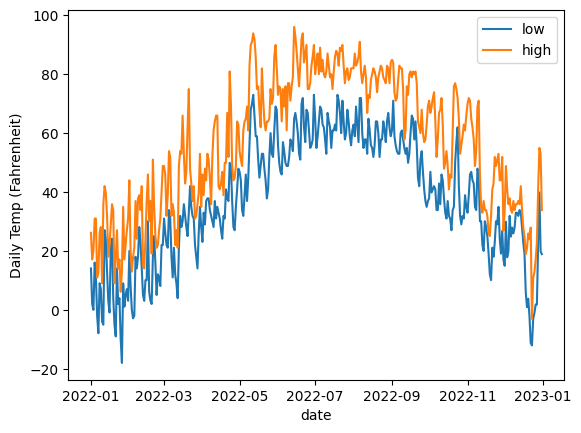

In [21]:
# Q3: what were the daily highs and lows at Madison's airport in 2022?
df = spark.sql("SELECT date, fahrenheit(record.tmin) as low, fahrenheit(record.tmax) as high FROM weather2022 WHERE id = 'USW00014837'").toPandas()
ax = df.set_index("date").plot.line()
ax.set_ylabel("Daily Temp (Fahrenheit)")

In [22]:
# Q4: what is the correlation between weather in Madison and Milwaukee?
from pyspark.sql.functions import corr
left = spark.table("weather2022").where("id = 'USW00014837'").select("date", col("record.tmax").alias("Madison"))
right = spark.table("weather2022").where("id = 'USW00014839'").select("date", col("record.tmax").alias("Milwaukee"))
left.join(right,"date").agg(corr("Madison", "Milwaukee").alias('c')).collect()

[Row(c=0.9786907979650685)]

<h1> Part 4


In [24]:
# Q5: does StationMax still work?
channel = grpc.insecure_channel('p5-db-1:5440')
stub = station_pb2_grpc.StationStub(channel)
r = stub.StationMax(station_pb2.StationMaxRequest(station="USW00014837"))
print(r)

_InactiveRpcError: <_InactiveRpcError of RPC that terminated with:
	status = StatusCode.UNKNOWN
	details = "Exception calling application: Error from server: code=1200 [Coordinator node timed out waiting for replica nodes' responses] message="Operation timed out - received only 2 responses." info={'consistency': 'THREE', 'required_responses': 3, 'received_responses': 2}"
	debug_error_string = "UNKNOWN:Error received from peer ipv4:172.18.0.4:5440 {created_time:"2023-03-22T07:02:31.050419662+00:00", grpc_status:2, grpc_message:"Exception calling application: Error from server: code=1200 [Coordinator node timed out waiting for replica nodes\' responses] message=\"Operation timed out - received only 2 responses.\" info={\'consistency\': \'THREE\', \'required_responses\': 3, \'received_responses\': 2}"}"
>

23/03/22 07:02:32 WARN ChannelPool: [s0|/172.18.0.3:9042]  Error while opening new channel (ConnectionInitException: [s0|connecting...] Protocol initialization request, step 1 (STARTUP {CQL_VERSION=3.0.0, DRIVER_NAME=DataStax Java driver for Apache Cassandra(R), DRIVER_VERSION=4.13.0, CLIENT_ID=6ba885e7-24fc-471f-8336-73019108f0bf, APPLICATION_NAME=Spark-Cassandra-Connector-local-1679467874387}): failed to send request (java.nio.channels.NotYetConnectedException))
23/03/22 07:02:44 WARN ChannelPool: [s0|/172.18.0.3:9042]  Error while opening new channel (ConnectionInitException: [s0|connecting...] Protocol initialization request, step 1 (STARTUP {CQL_VERSION=3.0.0, DRIVER_NAME=DataStax Java driver for Apache Cassandra(R), DRIVER_VERSION=4.13.0, CLIENT_ID=6ba885e7-24fc-471f-8336-73019108f0bf, APPLICATION_NAME=Spark-Cassandra-Connector-local-1679467874387}): failed to send request (java.nio.channels.NotYetConnectedException))
23/03/22 07:03:01 WARN ChannelPool: [s0|/172.18.0.3:9042]  Err

In [62]:
# Q6: does simulate_sensor still work?
simulate_sensor("USC00477115")

23/03/22 06:29:27 WARN ChannelPool: [s0|/172.18.0.3:9042]  Error while opening new channel (ConnectionInitException: [s0|connecting...] Protocol initialization request, step 1 (STARTUP {CQL_VERSION=3.0.0, DRIVER_NAME=DataStax Java driver for Apache Cassandra(R), DRIVER_VERSION=4.13.0, CLIENT_ID=d8a98a81-1c49-4a56-aa60-541f666a231f, APPLICATION_NAME=Spark-Cassandra-Connector-local-1679422387326}): failed to send request (com.datastax.oss.driver.shaded.netty.channel.StacklessClosedChannelException))


In [63]:
# Q7: how does refreshing the stale cache change the number of rows in weather2022?
print("BEFORE REFRESH:", spark.table("weather2022").count())
spark.sql("REFRESH TABLE weather2022")
print("AFTER REFRESH:", spark.table("weather2022").count())

BEFORE REFRESH: 1460
AFTER REFRESH: 1825


23/03/22 06:30:21 WARN ChannelPool: [s0|/172.18.0.3:9042]  Error while opening new channel (ConnectionInitException: [s0|connecting...] Protocol initialization request, step 1 (STARTUP {CQL_VERSION=3.0.0, DRIVER_NAME=DataStax Java driver for Apache Cassandra(R), DRIVER_VERSION=4.13.0, CLIENT_ID=d8a98a81-1c49-4a56-aa60-541f666a231f, APPLICATION_NAME=Spark-Cassandra-Connector-local-1679422387326}): failed to send request (com.datastax.oss.driver.shaded.netty.channel.StacklessClosedChannelException))
23/03/22 06:31:21 WARN ChannelPool: [s0|/172.18.0.3:9042]  Error while opening new channel (ConnectionInitException: [s0|connecting...] Protocol initialization request, step 1 (STARTUP {CQL_VERSION=3.0.0, DRIVER_NAME=DataStax Java driver for Apache Cassandra(R), DRIVER_VERSION=4.13.0, CLIENT_ID=d8a98a81-1c49-4a56-aa60-541f666a231f, APPLICATION_NAME=Spark-Cassandra-Connector-local-1679422387326}): failed to send request (com.datastax.oss.driver.shaded.netty.channel.StacklessClosedChannelExcept